# Peak Finder

This [Peak Finder](#Methodology) algorithm has been designed for the detection and grouping of time-domain electromagnetic (TEM) anomalies measured along flight lines.
Anomaly markers can be exported to Geoscience ANALYST, along with various metrics for characterization and targeting:

  <img align="right" width="50%" src="./images/peak_finder_app.png">
  
- Amplitude
- Dip direction
- Mad Tau (TEM data only)
- Anomaly skewness

While initially designed for TEM data, the same application can be used for the characterization of anomalies of mixed data types (e.g. magnetics, gravity, topography, etc.).


  

New user? Visit the [Getting Started](../installation.rst) page.

## Application
The following sections provide details on the different parameters controlling the application. Interactive widgets shown below are for demonstration purposes only.

In [1]:
from geoapps.processing import PeakFinder

app = PeakFinder(h5file=r"../../../assets/FlinFlon.geoh5")
app.main

## Project Selection

Select and connect to an existing **geoh5** project file containing data. 

In [2]:
app.project_panel

See the [Project Panel](base_application.ipynb#Project-Panel) page for more details.

## Object/Data Selection

List of `Curve` objects available containing line data. Multiple data channels and/or data groups can be selected. 

In [3]:
app.data_panel

### Flip Y-axis

Option to invert the data profile by a -1 multiplication. Useful for the detection of lows instead of highs.

In [4]:
app.flip_sign

ToggleButton(value=False, button_style='warning', description='Flip Y (-1x)')

## TEM data

Flag the selected data to be Time-Domain EM data. 

In [5]:
app.tem_box

This option enables the [TEM System](#TEM-System), [Time Groups](#Time-Groups) and [Decay Curve](#Decay-Curve) panels.

### TEM System

List of available TEM systems.
The application will attempt to assign the *Survey Type* based on
known channel names (e.g. *Sf* => *VTEM*).

In [6]:
app.system_options

Assigning the right time gates to each data channel is important for the calculation of the [Slanted Tau](#Slanted-Tau) parameter. 

### Time Groups

Pre-define groups of time channels for the labeling of anomalies. For example, anomalies found in both the `early` and `middle` time groups are labeled as `early+middle` with the corresponding color code. 

See the [Methodology](#Methodology) section for details on the grouping.

In [7]:
app.groups_panel

### Decay Curve

Plot of peak values as a function of time for the nearest anomaly to the [Center](#Center) location.

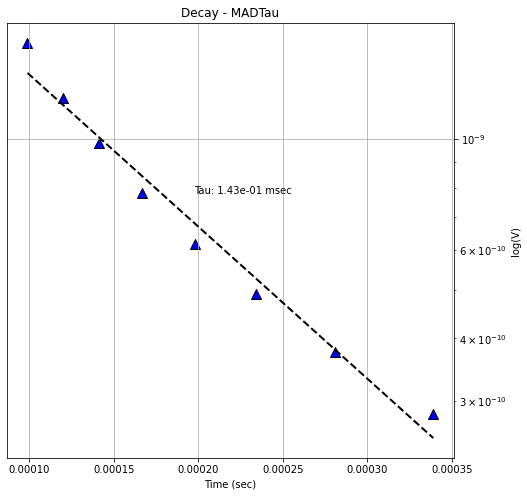

In [8]:
app.decay_figure


#### Slanted Tau

This pseudo-decay curve can be used for the calculation of the `Slanted Tau`, or `Mad Tau`, as defined by the slope of the linear fit of log( `dB/dt`(V)) as a function `time` (s). 

\begin{equation}
\tau = \cot(\theta) \approx \frac{\Delta t}{\Delta log(dB/dt)}
\end{equation}
    
where $\Delta$ denotes the varation of time $t$ and $dB/dt$ over the selected group of time channels ([Nabighian & Macnea, 1991](https://library.seg.org/doi/epdf/10.1190/1.9781560802686.ch6)).

## Line Selection

Selection of a channel representing the line identifier and specific line number.

In [9]:
app.lines.main

The detection algorithm is applied immediately on the selected line as a test dataset. Users are invited to adjust the different [Detection Parameters](#Detection-Parameters) before [Executing](#Process-All) the process on all lines.

## Profile Plot

Data profile plot with detected anomalies color coded by [Groups](#Grouping). 

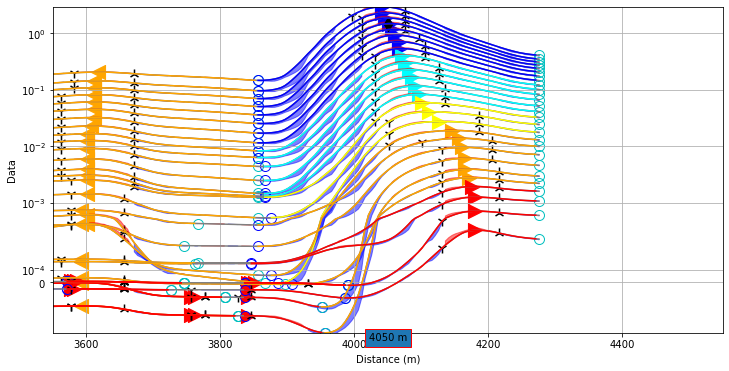

In [10]:
app.figure

Anomalies are detected when a peak (maximum) can be found between two lows (minimum) and two inflection points. 
Triangles marking the peaks position point in the estimated dip direction determined by:

- (TEM data) the peak migration direction
- (None-TEM) the skew direction

## Visual Parameters

Parameters controlling the [Profile Plot](#Profile-Plot).

In [11]:
app.visual_parameters

### Center
Position of the plotting window along the selected line.

### Width
Width of the plotting window

### X-axis label
Units displayed along the x-axis

### Y-axis scaling
Normalization of the data displayed along the Y-axis

### Symlog
Symmetric logarithmic option such that both positive and negative data can be displayed in log space.

#### Linear threshold

Limits for the log scale plot around zero. Values between the (+/-) threshold are plotted in linear scale. 

## Detection Parameters

Parameters controlling the filtering and grouping of positive peak anomalies.

In [12]:
app.detection_parameters

<img align="center" width="75%" src="./images/peak_finder_parameters.png">


### Minimum Amplitude

Threshold value ($\delta_A$) for filtering small anomalies:

\begin{equation}
\delta_A = \|\frac{d_{max} - d_{min}}{d_{min}}\| * 100
\end{equation}

Set as a percent (%) of the data anomaly over its minimum value.


### Minimum Data Value

Minimum absolute data value ($\delta_d$) used by the algorithm:
\begin{equation}
d_i = 
\begin{cases}
d_i & \;\text{for } d_i > \delta_d \\
nan & \;\text{for } d_i \leq \delta_d\\
\end{cases}
\end{equation}

### Minimum Width

Minimum anomaly width (m) as measured from start to end (consecutive lows).


### Maximum Peak Migration

Threshold applied on the grouping of anomalies based on the lateral shift of peaks.

### Minimum number of channels

Minimum number of data channels required to form a group.


<img align="right" width="50%" src="./images/peak_smoothing.png">


### Smoothing

Parameter controlling the running mean averaging:

$d_i = \frac{1}{N}\sum_{j=-\frac{N}{2}}^{\frac{N}{2}}d_{i+j}$

where `N` is the number of along line neighbours used for the averaging. The averaging becomes one sided at both ends of the profile. Positive (blue) and negative (red) residuals between the original and smoothed profile are shown for reference.


### Use residual

Option to use the residual between the recorded and smoothed data. Useful to highlight smaller anomalies within larger trends.


## Model Panel

Option to show `Surface` model and `Points` data.

In [13]:
app.model_figure

FigureWidget({
    'data': [{'type': 'scatter3d', 'uid': '98fa1046-0901-4bb4-86e9-236358609c56'},
            …

### Model Parameters

Set various parameters to control the 3D plot.

In [14]:
app.model_parameters

#### Log Values

Option to plot the model values in base `log10`

#### Minimum

Set the lower color range.

#### Maximum

Set the upper color range

#### Colormap

Select a colormap 

#### Opacity

Change the transparency of the surface model.

### DOI Parameters

Add a Depth of Investigation (DOI) mask to the surface model.

In [15]:
app.doi_parameters

#### DOI Layer

Select a model value corresponding to the DOI mask.

#### DOI %

Cutoff DOI value.

#### Revert

Use the reciprocal of the DOI values as mask.

### Scatter Parameters

Add scatter `Points` data to the plot, such as borehole data.

In [16]:
app.scatter_parameters

#### Points

Select `Points` object to display on 3D plot.

#### Values

Select `Data` associated with the `Points` object to display.

#### Slice width

Maxmimum search distance around the selected [Line](#Line-Selection)

#### Marker Size

Adjust the `Points` markers size. 

## Output Panel

Run and export anomaly markers.

In [17]:
app.output_panel

### Process All

Run the search algorihtm on all lines. This process is run in parallel using [Dask](https://dask.org/).

### Export Peaks

Export anomaly group markers to the target `geoh5` project.

### All Markers

Write the full set of markers (min, max, inflections) for all peaks on every data channels.

See the [Output Panel](base_application.ipynb#Output-Panel) page for more details.

## Methodology

This section provides technical details regarding the algorithm used for the detection of 1D anomalies. 

Anomalies are identified from the detection of maximum, minimum and inflection points calculated from the first and second order derivatives of individual data channels. The algorithm relies on the [Numpy.fft](https://numpy.org/doc/stable/reference/routines.fft.html) routine for the calculation of derivatives in the Fourier domain.

[Detection Parameters](#Detection-Parameters) are available for filtering and grouping co-located anomalies. The selection process is done in the following order:

### Primary detection

Loop over the selected data channels:

1. Apply the [Minimum Data Value](#Minimum-Data-Value) threshold.
2. For every maximum (peak) found on a profile, look on either side for inflection and minimum points. This forms an anomaly.
3. Keep all anomalies larger than the [Minimum Amplitude](#Minimum-Amplitude)

### Grouping

Anomalies found along individual data channels are grouped based on spatial proximity:

1. Find all peaks within the [Maximum Peak Migration](#Maximum-Peak-Migration) distance. The nearest peak is used if multiple peaks are found on a single channel.
2. Create an anomaly group that satisfies the following criteria:
    - The data channels must be part of a continuous series (maximum of one channel skip is allowed)
    - A group must satisfy the [Minimum number of channels](#Minimum-number-of-channels)
3. For TEM data, an ID gets assigned based on the largest overlap between the labeled data channels and the pre-defined [Time Groups](#Time-Groups).

Need help? Contact us at support@mirageoscience.com

In [18]:
import matplotlib.pyplot as plt
app.figure.savefig("images/peak_finder_thumbnail.png", dpi=300, bbox_inches='tight')